In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from torch.optim import lr_scheduler
import mlflow

In [13]:
# hyperparameters
# NUM_EPOCHS = 25
# TODO: update to 50 in final experiments
NUM_EPOCHS = 1 # new, converged in this time
# TODO: update to 64 once larger dataset is available
BATCH_SIZE = 4
LAYERS_TRAINED = 1
LEARNING_RATE = 0.001
MOMENTUM = 0.9
RANDOM_SEED = 15

# use balanced torch imagefolder dataset
experiment = 'upperlower'
target_num_of_classes = 2

# add seconds to run training to mlflow!
runtime = 0

# set random seed for both CUDA and CPU with manual seed
torch.manual_seed(RANDOM_SEED)

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(3),
        transforms.GaussianBlur(3),
        transforms.ColorJitter(brightness=[0.95,1.05], contrast=[0.8,1.2]),
        transforms.RandomAffine(degrees=[-5,5], shear=(1,10,1,10), fill=255),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2])
    ]),
}


data_dir = f'/home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/{experiment}'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=0) # seed this random
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names

['low', 'up']

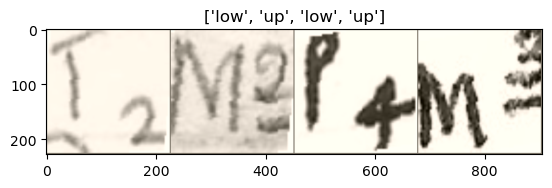

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

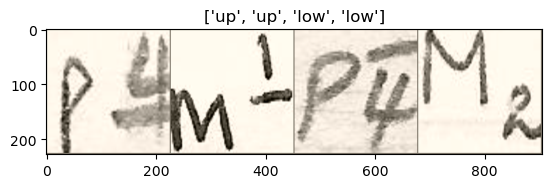

In [7]:
# Get a batch of test data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# LOAD BASE MODEL

# model = torchvision.models.vit_b_16(weights='DEFAULT')
# model = torchvision.models.alexnet(weights='DEFAULT')
# model = torchvision.models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')
# model = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
# model = torchvision.models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')
# model = torchvision.models.resnet101(weights='ResNet101_Weights.IMAGENET1K_V2')

# REPLACE LAYER

# replace last layer of model (syntax depends on model submodule naming)
# alexnet
# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_ftrs, target_num_of_classes)

# vit
# num_ftrs = model.heads[0].in_features
# model.heads[0] = nn.Linear(num_ftrs, target_num_of_classes)

# efficientnet
# num_ftrs = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(num_ftrs, target_num_of_classes)

# vgg
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, target_num_of_classes)

# densenet
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, target_num_of_classes)

# resnet
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, target_num_of_classes)

# FREEZING

for param in list(model.parameters())[:-1*(LAYERS_TRAINED)]:
    param.requires_grad = False

# OPTIMIZER

# vit 
# optimizer = optim.SGD(model.heads[0].parameters(), lr=0.001, momentum=0.9)
# alexnet
# optimizer = optim.SGD(model.classifier[6].parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
# efficientnet
# optimizer = optim.SGD(model.classifier[1].parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
# vgg
optimizer = optim.SGD(model.classifier[6].parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
# densenet
# optimizer = optim.SGD(model.classifier.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
# resnet
# optimizer = optim.SGD(model.classifier.fc.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# model = model.to(device)
# criterion = nn.CrossEntropyLoss()

for param in model.parameters():
    print(param.requires_grad)
model.forward

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True


<bound method VGG.forward of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, st

In [ ]:
# Add softmax to end of model for valid confidence scores
inputs = inputs.to(device)
print(model(inputs[0].unsqueeze(0)))

model = nn.Sequential(
    model,
    nn.Softmax(1)
)
print(model(inputs[0].unsqueeze(0)))

tensor([[ 0.3345, -0.1504]], grad_fn=<AddmmBackward0>)
tensor([[0.4720, 0.5280]], grad_fn=<SoftmaxBackward0>)


In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_train_acc = 0.0
    best_test_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val':
                best_test_acc = epoch_acc.item()
            if phase == 'train':
                best_train_acc = epoch_acc.item()

        print()

    print(f'Best val Acc: {best_test_acc:4f}')

    return model, best_train_acc, best_test_acc

In [42]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [43]:
model, train_acc, val_acc = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/0
----------
train Loss: 0.7278 Acc: 0.6210
val Loss: 0.8134 Acc: 0.5260

Best val Acc: 0.525974


In [44]:
print(val_acc)

0.525974025974026


In [45]:
print(train_acc)

0.6209944751381216


In [46]:
visualize_model(model)

plt.ioff()
plt.show()

KeyError: 'test'

<Figure size 640x480 with 0 Axes>

In [ ]:
model_pt_filename = f'{experiment}.pt'
torch.save(model, model_pt_filename)

In [ ]:
%env MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
mlflow.set_experiment(experiment)

params = {
    'data_v': [3,4,5],
    'train_size': dataset_sizes['train'],
    'test_size': dataset_sizes['test'],
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'base_model_path': type(model),
    'layers_trained': LAYERS_TRAINED,
    'learning_rate': LEARNING_RATE,
    'momentum': MOMENTUM
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("training accuracy", train_acc)
    mlflow.log_metric("test accuracy", val_acc)

    mlflow.log_artifact(model_pt_filename)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "EfficientNet with new dataset, one epoch to test script")

env: MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
